In [1]:
from cartpole import *
import pytorch_utils as ptu
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 10)

In [2]:
ptu.init_gpu(use_gpu=False)  # use cpu

env = gym.make("CartPole-v1")
env.seed(42)

ptu.set_random_seed(42)

obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n

policy = ptu.MLPCategoricalpolicy(
    obs_dim, act_dim, hidden_sizes=[64, 64], activation="relu_inplace"
).to(ptu.device)
print(policy)

GPU not detected. Defaulting to CPU.
MLPCategoricalpolicy(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=2, bias=True)
    (5): Identity()
  )
)


In [3]:
lr = 3e-3

# 1
## 1. REINFORCE
Implement a vanilla reinforce algorithm given by the following gradient update for your
policy.

In [4]:
mean_reward_reinforce, train_loss_reinforce = reinforce(
    env,
    policy,
    num_itrs=200,
    batch_size=500,
    gamma=0.99,
    lr=lr)




100%|██████████| 200/200 [00:39<00:00,  5.08it/s]


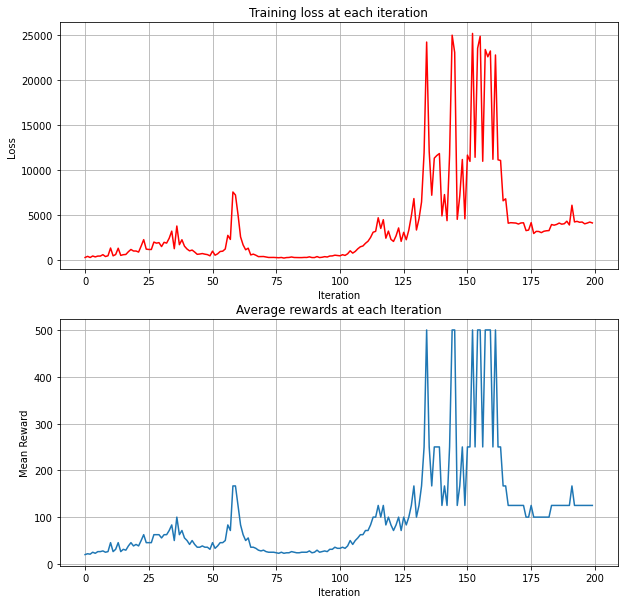

In [5]:
plot_loss_rew(train_loss_reinforce, mean_reward_reinforce)

## 1.2 Reward to go
Implement the policy gradient algorithm using update rule

100%|██████████| 200/200 [00:39<00:00,  5.03it/s]


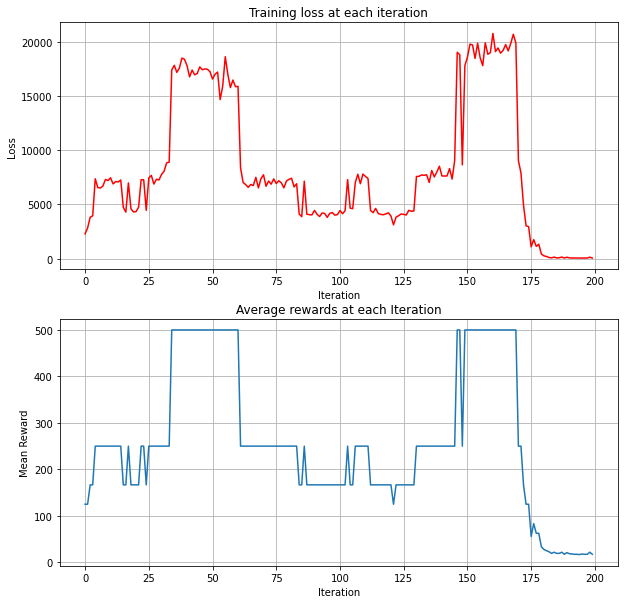

In [6]:
mean_reward_rtg, train_loss_rtg = vpg_with_baseline(
    env,
    policy,
    num_itrs=200,
    batch_size=500,
    gamma=0.99,
    lr=lr,
    baseline=False,
)
plot_loss_rew(train_loss_rtg, mean_reward_rtg)




## 1.3 Reward to go + baseline
To reduce the variance of the estimated returns, subtract the returns using a constant
b such that the mean of the modified returns is 0. 


100%|██████████| 200/200 [00:38<00:00,  5.22it/s]


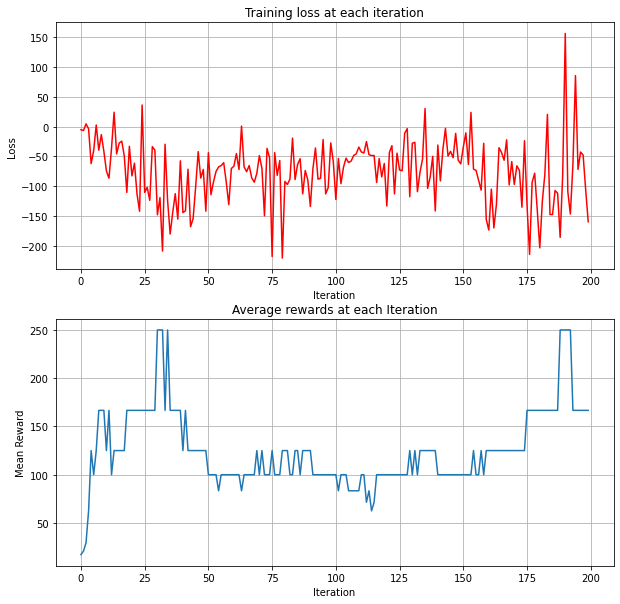

In [7]:
mean_reward_baseline, train_loss_baseline = vpg_with_baseline(
    env,
    policy,
    num_itrs=200,
    batch_size=500,
    gamma=0.99,
    lr=lr,
    baseline=True,
)
plot_loss_rew(train_loss_baseline, mean_reward_baseline)

Policy gradient methods are unbiasd but high variance. This means the training process is extremely unstable and usually hard to converge. In order to reduce the variance, we apply the reward to go formulation and subtract the baseline. Subtracing the baseline is also unbiased. In this example, we use the emperical mean as the baseline.

Although the final result collapse as well and it don't seems to be be than previous plots. The variance is smaller than reinforce and reward to go version. Therefore, the learning curve is the most stable amoung 3 methods. Each model should be tune with the associate hyperparemeters. In order to fairly compare amoung 3 methods, I use same network size and depth and same learning rate. With an good learning rate for baseline case, the result should be the best amoung 3 methodes.

In order to better reduced the variance, we can use a neural network to estimate the value function. The objective becomes the following:
$$ \nabla_{\theta}J(\pi_{theta}) = E_{\tau \sim \pi_{theta}} \Big[\sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t|s_t) A^{\pi_{\theta}}(s_t,a_t)\Big]$$

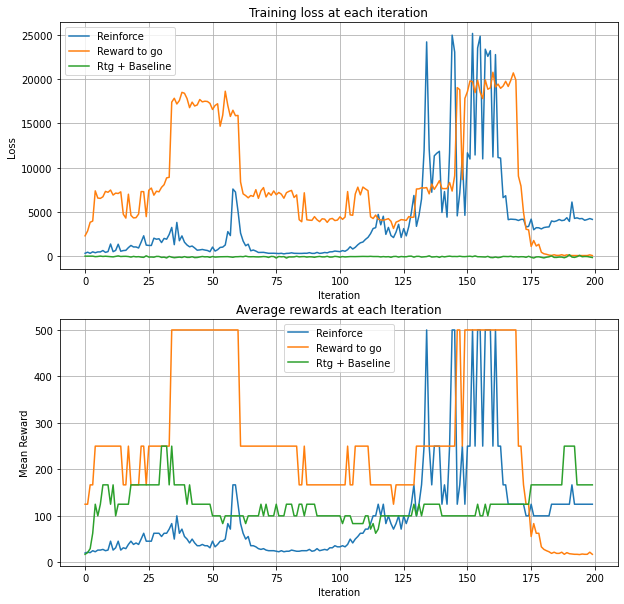

In [8]:
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(train_loss_reinforce, label= "Reinforce")
ax1.plot(train_loss_rtg, label="Reward to go")
ax1.plot(train_loss_baseline, label="Rtg + Baseline")

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')
ax1.set_title('Training loss at each iteration')
ax1.grid(True)
ax1.legend()


ax2.plot(mean_reward_reinforce, label= "Reinforce")
ax2.plot(mean_reward_rtg, label="Reward to go")
ax2.plot(mean_reward_baseline, label="Rtg + Baseline")


ax2.set_xlabel('Iteration')
ax2.set_ylabel('Mean Reward')
ax2.set_title('Average rewards at each Iteration')
ax2.grid(True)
ax2.legend()
plt.show()

## 1.4 Train the policy with the update in question 1.3 with following batch sizes - {600,800,1000}

In [9]:
# ===============================================================
# 600
lr = 7e-3
mean_reward_baseline_600, train_loss_baseline_600 = vpg_with_baseline(
    env,
    policy,
    num_itrs=200,
    batch_size=600,
    gamma=0.99,
    lr=lr,
    baseline=True,
)

mean_reward_baseline_800, train_loss_baseline_800 = vpg_with_baseline(
    env,
    policy,
    num_itrs=200,
    batch_size=800,
    gamma=0.99,
    lr=lr,
    baseline=True,
)

mean_reward_baseline_1000, train_loss_baseline_1000 = vpg_with_baseline(
    env,
    policy,
    num_itrs=200,
    batch_size=1000,
    gamma=0.99,
    lr=lr,
    baseline=True,
)

100%|██████████| 200/200 [01:26<00:00,  2.33it/s]


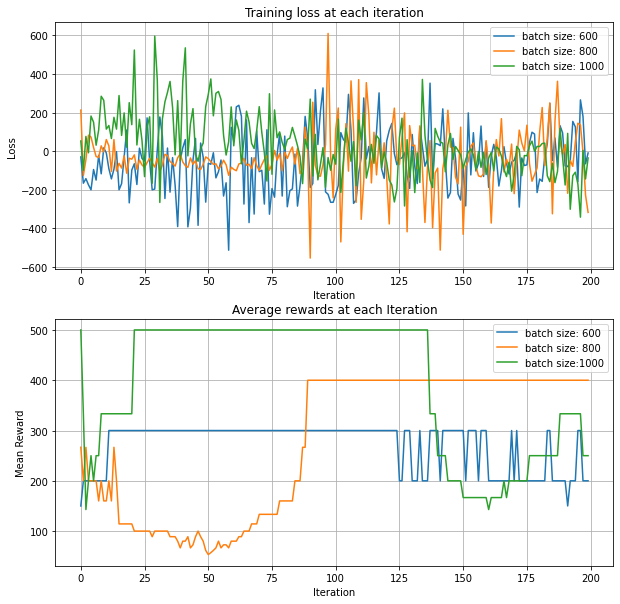

In [10]:
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(train_loss_baseline_600, label= "batch size: 600")
ax1.plot(train_loss_baseline_800, label="batch size: 800")
ax1.plot(train_loss_baseline_1000, label="batch size: 1000")

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')
ax1.set_title('Training loss at each iteration')
ax1.grid(True)
ax1.legend()


ax2.plot(mean_reward_baseline_600, label= "batch size: 600")
ax2.plot(mean_reward_baseline_800, label="batch size: 800")
ax2.plot(mean_reward_baseline_1000, label="batch size:1000")


ax2.set_xlabel('Iteration')
ax2.set_ylabel('Mean Reward')
ax2.set_title('Average rewards at each Iteration')
ax2.grid(True)
ax2.legend()
plt.show()

Since we are using MC estimation, increasing batch size did improve the training perframnce. A larger batcg size thend to converge faster.

# 2 two Link Arm

In [11]:
env = gym.make(f"modified_gym_env:ReacherPyBulletEnv-v1", rand_init=True)
env.seed(0)

ptu.set_random_seed(0)

obs_dim = env.observation_space.shape[0] - 1  #? Why?
act_dim = env.action_space.shape[0]

policy = ptu.MLPDiagGaussianpolicy(
    obs_dim,
    act_dim,
    hidden_sizes=[128, 128],
    activation="relu",
    
).to(ptu.device)
print(policy)

mean_reward_rtg, train_loss_rtg = vpg_with_baseline(
    env,
    policy,
    num_itrs=200,
    batch_size=2000,
    gamma=0.9,
    lr=1e-2,
    baseline=True,
    baseline_type="average",
    verbose=True
)


pybullet build time: Sep 20 2021 20:34:14
/home/yiw084/Desktop/UCSD/FA_21/ECE276c/HW1/gym/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


MLPDiagGaussianpolicy(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
    (5): Identity()
  )
)


  0%|          | 0/200 [00:00<?, ?it/s]

argv[0]=
argv[0]=
Episode [1/200] loss: -2.01, mean reward: -23.56, n_traj: 17


  5%|▌         | 10/200 [00:18<05:53,  1.86s/it]

Episode [11/200] loss: -0.71, mean reward: -28.23, n_traj: 14


 10%|█         | 20/200 [00:36<05:28,  1.82s/it]

Episode [21/200] loss: 4.32, mean reward: -37.10, n_traj: 15


 15%|█▌        | 30/200 [00:55<05:12,  1.84s/it]

Episode [31/200] loss: -3.94, mean reward: -35.86, n_traj: 16


 20%|██        | 40/200 [01:13<04:55,  1.85s/it]

Episode [41/200] loss: -1.43, mean reward: -23.96, n_traj: 18


 25%|██▌       | 50/200 [01:31<04:35,  1.84s/it]

Episode [51/200] loss: -3.23, mean reward: -30.00, n_traj: 14


 30%|███       | 60/200 [01:50<04:18,  1.85s/it]

Episode [61/200] loss: 0.18, mean reward: -22.58, n_traj: 17


 35%|███▌      | 70/200 [02:09<04:02,  1.87s/it]

Episode [71/200] loss: -1.34, mean reward: -25.26, n_traj: 15


 40%|████      | 80/200 [02:27<03:40,  1.84s/it]

Episode [81/200] loss: 2.60, mean reward: -20.54, n_traj: 16


 45%|████▌     | 90/200 [02:46<03:28,  1.89s/it]

Episode [91/200] loss: -0.06, mean reward: -19.60, n_traj: 17


 50%|█████     | 100/200 [03:04<03:07,  1.87s/it]

Episode [101/200] loss: -0.61, mean reward: -16.06, n_traj: 17


 55%|█████▌    | 110/200 [03:24<02:51,  1.91s/it]

Episode [111/200] loss: -0.74, mean reward: -20.52, n_traj: 14


 60%|██████    | 120/200 [03:42<02:29,  1.87s/it]

Episode [121/200] loss: -0.89, mean reward: -9.03, n_traj: 27


 65%|██████▌   | 130/200 [04:01<02:09,  1.85s/it]

Episode [131/200] loss: -1.07, mean reward: -8.84, n_traj: 25


 70%|███████   | 140/200 [04:20<01:51,  1.86s/it]

Episode [141/200] loss: -0.37, mean reward: -7.07, n_traj: 27


 75%|███████▌  | 150/200 [04:38<01:33,  1.86s/it]

Episode [151/200] loss: 0.43, mean reward: -5.87, n_traj: 36


 80%|████████  | 160/200 [04:57<01:13,  1.84s/it]

Episode [161/200] loss: 0.18, mean reward: -4.76, n_traj: 47


 85%|████████▌ | 170/200 [05:16<00:56,  1.89s/it]

Episode [171/200] loss: -0.26, mean reward: -3.91, n_traj: 58


 90%|█████████ | 180/200 [05:34<00:37,  1.89s/it]

Episode [181/200] loss: -0.68, mean reward: -4.39, n_traj: 54


 95%|█████████▌| 190/200 [05:53<00:18,  1.85s/it]

Episode [191/200] loss: -0.77, mean reward: -3.31, n_traj: 72


100%|██████████| 200/200 [06:12<00:00,  1.86s/it]


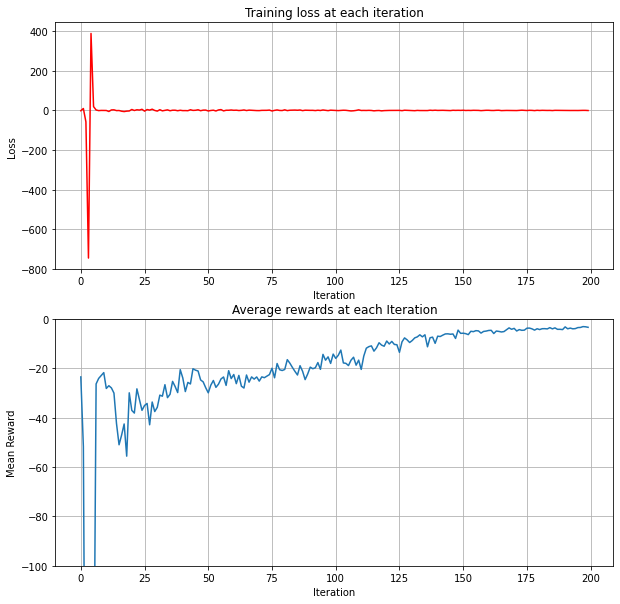

In [15]:

f, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(train_loss_rtg, '-r')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')
ax1.set_title('Training loss at each iteration')
ax1.grid(True)
ax2.plot(mean_reward_rtg)
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Mean Reward')
ax2.set_title('Average rewards at each Iteration')
ax2.set_ylim([-100, 0])
ax2.grid(True)
plt.show()

In [13]:
num_episodes = 100
for i in range(num_episodes):
        obs = env.reset()
        done = False
        total_rew = 0
        while not done:
            act, _ = policy.get_action(ptu.to_torch(obs), deterministic=True)
            act = ptu.to_numpy(act)
            
            obs, rew, done, _ = env.step(act)
            total_rew += rew
print(f"Mean Reward: {total_rew / num_episodes}")        

Mean Reward: -0.022158275674924316
